# Analyze Results

In [1]:
# global imports
import numpy as np
from scipy.stats import gaussian_kde
# pyspark
import findspark
findspark.init()
import pyspark
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as W
# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

spark = SparkSession.builder.getOrCreate()
# specifications for visualizations
plt.style.use('seaborn')

# Import Data

In [2]:
# import data
%store -r ml_results

In [3]:
# area under the precision-recall curve
areaUnderPR = spark.createDataFrame(ml_results[1])
areaUnderPR.show(2)

+-------------------+---------+
|             recall|precision|
+-------------------+---------+
|                0.0|      1.0|
|0.09859154929577464|      1.0|
+-------------------+---------+
only showing top 2 rows



In [4]:
# regression coefficients
coefficients = ml_results[2]

In [5]:
# predictions data frame
test = spark.createDataFrame(ml_results[0])
test.show(2)

+--------------------+-----+--------------------+--------------------+----------+
|           count_vec|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|         (495,[],[])|    0|[0.17159534778592...|[0.54279388308167...|       0.0|
|(495,[1,5,6,7,10,...|    0|[0.01856401616294...|[0.50464087076238...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 2 rows



In [6]:
# import data
%store -r dfs

In [7]:
# import vocabulary
vocab = dfs[3]

In [8]:
# data frame of correct predictions
correct = test.where(W.col('label')==W.col('prediction'))
correct.show(2)

+--------------------+-----+--------------------+--------------------+----------+
|           count_vec|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|         (495,[],[])|    0|[0.17159534778592...|[0.54279388308167...|       0.0|
|(495,[1,5,6,7,10,...|    0|[0.01856401616294...|[0.50464087076238...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 2 rows



In [9]:
# data frame of incorrect predictions
incorrect = test.where(W.col('label')!=W.col('prediction'))
incorrect.show(2)

+--------------------+-----+--------------------+--------------------+----------+
|           count_vec|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(495,[4,33,121],[...|    0|[-0.0038893774010...|[0.49902765687546...|       1.0|
|     (495,[1],[1.0])|    1|[0.15842415256429...|[0.53952340879091...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 2 rows



# Precision-Recall Curve

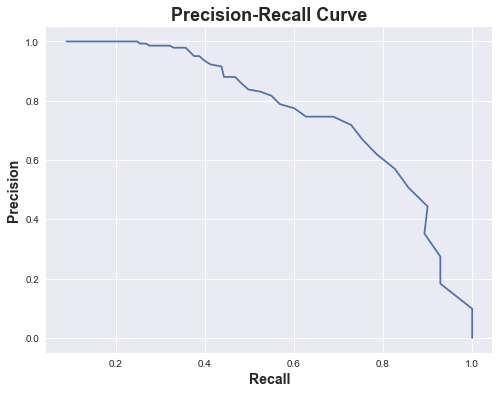

In [10]:
pr_pandas = areaUnderPR.toPandas()
# create a precision recall curve
plt.figure(figsize=(8,6))
plt.plot(pr_pandas['precision'],pr_pandas['recall'])
plt.xlabel('Recall',fontsize=14,weight='bold')
plt.ylabel('Precision',fontsize=14,weight='bold')
plt.title('Precision-Recall Curve',fontsize=18,weight='bold')
plt.show()

In [11]:
# create evaluator
auPR =  BinaryClassificationEvaluator().setMetricName('areaUnderPR')
# print area under PR
print('Area under precision-recall curve: ',auPR.evaluate(test))

Area under precision-recall curve:  0.5513999729095901


# Regression Coefficients

In [12]:
# relate regression coefficients with the words
coef_zipped = zip(coefficients,vocab)
coef_sort = sorted(coef_zipped)
print('Words corresponding to the largest coefficients: ',coef_sort[-5:])
print('Words corresponding to the smallest coefficients: ',coef_sort[0:5])

Words corresponding to the largest coefficients:  [(0.2400232457587068, 'realize'), (0.24213048564920814, 'return'), (0.2426261528498454, 'low'), (0.26982527695939296, 'apple'), (0.27904821631890503, 'stopped')]
Words corresponding to the smallest coefficients:  [(-0.3748677503204451, 'message'), (-0.3594856461011295, 'satisfied'), (-0.34490157292911616, 'dislike'), (-0.3399070898497102, 'expected'), (-0.3390402836556773, 'capability')]


Words corresponding to the largest coefficients relate to negative terms, and words corresponding to the smallest coefficients relate to positive terms. All coefficients are fairly small, meaning each individual word does not carry significant weight for determining whether a review is positive or negative. Furthermore, some negative words, like "dislike," have a negative coefficient which indicates that the model could be improved. 

# Raw Predictions

## Positive Reviews

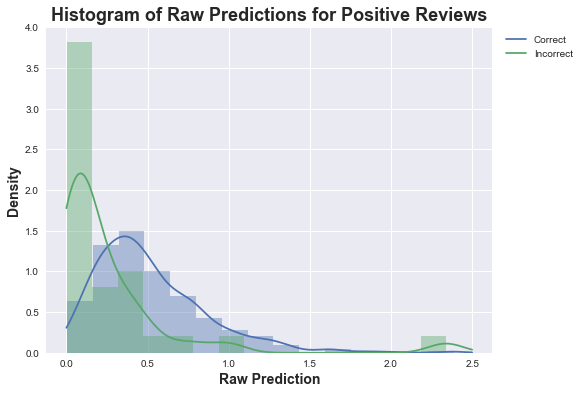

In [13]:
# create lists
pos_correct = correct.where(W.col('label')==0).select('rawPrediction').rdd.map(lambda row:row[0][0]).collect()
pos_incorrect = incorrect.where(W.col('label')==0).select('rawPrediction').rdd.map(lambda row:row[0][1]).collect()
# obtain density
xs = np.linspace(0,2.5,200)
pos_correct_density = gaussian_kde(pos_correct)
pos_correct_density.covariance_factor = lambda : .25
pos_correct_density._compute_covariance()
pos_incorrect_density = gaussian_kde(pos_incorrect)
pos_incorrect_density.covariance_factor = lambda : .25
pos_incorrect_density._compute_covariance()
# create a histogram of text length by label
plt.figure(figsize=(8,6))
plt.hist(pos_correct,bins=15,density=True,alpha=0.4)
plt.hist(pos_incorrect,bins=15,density=True,alpha=0.4)
plt.plot(xs,pos_correct_density(xs),color='C0')
plt.plot(xs,pos_incorrect_density(xs),color='C1')
plt.xlabel('Raw Prediction',fontsize=14,weight='bold')
plt.ylabel('Density',fontsize=14,weight='bold')
plt.title('Histogram of Raw Predictions for Positive Reviews',fontsize=18,weight='bold')
# create legend
plt.legend(['Correct','Incorrect'],bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
plt.show()

In [14]:
# output median, mean, and std
print("Median raw prediction for correctly classified positive reviews: ", np.median(pos_correct))
print("Mean raw prediction for correctly classified positive reviews: ", np.mean(pos_correct))
print("Std of raw prediction for correctly classified positive reviews: ", np.std(pos_correct))

Median raw prediction for correctly classified positive reviews:  0.43544854023410695
Mean raw prediction for correctly classified positive reviews:  0.5159556237603393
Std of raw prediction for correctly classified positive reviews:  0.3481256140428173


In [15]:
# output median, mean, and std
print("Median raw prediction for misclassified positive reviews: ", np.median(pos_incorrect))
print("Mean raw prediction for misclassified positive reviews: ", np.mean(pos_incorrect))
print("Std of raw prediction for misclassified positive reviews: ", np.std(pos_incorrect))

Median raw prediction for misclassified positive reviews:  0.111977554279524
Mean raw prediction for misclassified positive reviews:  0.27022497187558026
Std of raw prediction for misclassified positive reviews:  0.43341910204105744


Positive reviews that are correctly classified are predicted with more confidence than positive reviews that are incorrectly classified. 

## Negative Reviews

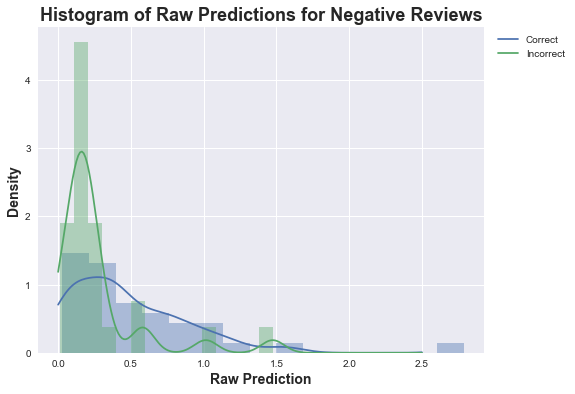

In [16]:
# create lists
neg_correct = correct.where(W.col('label')==1).select('rawPrediction').rdd.map(lambda row:row[0][1]).collect()
neg_incorrect = incorrect.where(W.col('label')==1).select('rawPrediction').rdd.map(lambda row:row[0][0]).collect()
# obtain density
xs = np.linspace(0,2.5,200)
neg_correct_density = gaussian_kde(neg_correct)
neg_correct_density.covariance_factor = lambda : .25
neg_correct_density._compute_covariance()
neg_incorrect_density = gaussian_kde(neg_incorrect)
neg_incorrect_density.covariance_factor = lambda : .25
neg_incorrect_density._compute_covariance()
# create a histogram of text length by label
plt.figure(figsize=(8,6))
plt.hist(neg_correct,bins=15,density=True,alpha=0.4)
plt.hist(neg_incorrect,bins=15,density=True,alpha=0.4)
plt.plot(xs,neg_correct_density(xs),color='C0')
plt.plot(xs,neg_incorrect_density(xs),color='C1')
plt.xlabel('Raw Prediction',fontsize=14,weight='bold')
plt.ylabel('Density',fontsize=14,weight='bold')
plt.title('Histogram of Raw Predictions for Negative Reviews',fontsize=18,weight='bold')
# create legend
plt.legend(['Correct','Incorrect'],bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
plt.show()

In [17]:
# output median, mean, and std
print("Median raw prediction for correctly classified negative reviews: ", np.median(neg_correct))
print("Mean raw prediction for correctly classified negative reviews: ", np.mean(neg_correct))
print("Std of raw prediction for correctly classified negative reviews: ", np.std(neg_correct))

Median raw prediction for correctly classified negative reviews:  0.3940179342877622
Mean raw prediction for correctly classified negative reviews:  0.5367694080840996
Std of raw prediction for correctly classified negative reviews:  0.5254148518381028


In [18]:
# output median, mean, and std
print("Median raw prediction for misclassified negative reviews: ", np.median(neg_incorrect))
print("Mean raw prediction for misclassified negative reviews: ", np.mean(neg_incorrect))
print("Std of raw prediction for misclassified negative reviews: ", np.std(neg_incorrect))

Median raw prediction for misclassified negative reviews:  0.171595347785929
Mean raw prediction for misclassified negative reviews:  0.269454601132967
Std of raw prediction for misclassified negative reviews:  0.31297599902738155


Positive reviews that are correctly classified are predicted with more confidence than positive reviews that are incorrectly classified. 

# Words

In [19]:
# function for creating key and value pair of a row
def key_val(row):
    new_row = [(i,row[i]) for i in range(len(row))]
    return new_row

In [20]:
cloud = WordCloud()
# function for creating a word cloud
def createWordCloud(dic):
    plt.figure(figsize=(8,6))
    cloud.generate_from_frequencies(dic)
    plt.imshow(cloud)
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

## Correctly Classified Positive Reviews

In [21]:
# create dictionary of indices and word counts
correct_pos_dict = correct.where(W.col('label')==0)\
                          .select('count_vec').rdd\
                          .map(lambda row: row.count_vec.toArray())\
                          .map(lambda row: key_val(row))\
                          .flatMap(lambda row: row)\
                          .reduceByKey(lambda x,y: x+y)\
                          .mapValues(lambda x: int(x))\
                          .collectAsMap()

In [22]:
# update the dictionary so the keys correspond to words
for i in range(0,len(vocab)):
    correct_pos_dict[vocab[i]] = correct_pos_dict.pop(i)

In [23]:
# get dictionary with values greater than 0
correct_pos_clean = {}
for k in correct_pos_dict.keys():
    if correct_pos_dict[k] > 0:
        correct_pos_clean[k] = correct_pos_dict[k]

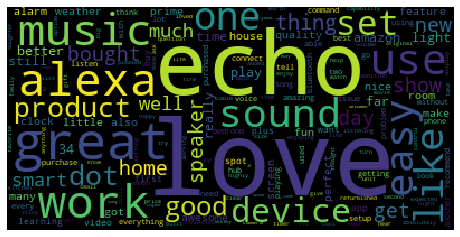

In [24]:
# create word cloud
createWordCloud(correct_pos_clean)

Common words in positive reviews are fairly generic adjectives to describe something good. 

## Correctly Classified Negative Reviews

In [25]:
# create dictionary of indices and word counts
correct_neg_dict = correct.where(W.col('label')==1)\
                          .select('count_vec').rdd\
                          .map(lambda row: row.count_vec.toArray())\
                          .map(lambda row: key_val(row))\
                          .flatMap(lambda row: row)\
                          .reduceByKey(lambda x,y: x+y)\
                          .mapValues(lambda x: int(x))\
                          .collectAsMap()

In [26]:
# update the dictionary so the keys correspond to words
for i in range(0,len(vocab)):
    correct_neg_dict[vocab[i]] = correct_neg_dict.pop(i)

In [27]:
# get dictionary with values greater than 0
correct_neg_clean = {}
for k in correct_neg_dict.keys():
    if correct_neg_dict[k] > 0:
        correct_neg_clean[k] = correct_neg_dict[k]

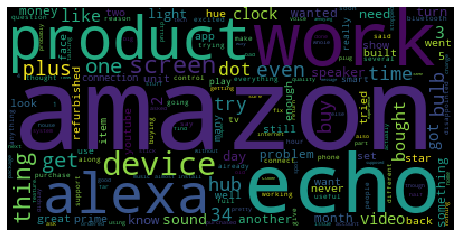

In [28]:
# create word cloud
createWordCloud(correct_neg_clean)

Common words in correctly classified negative reviews have words that are specific to an issue. Because users encounter a myriad of problems with Alexas, negative reviews contain many different terms. This makes it challenging for the model to classify negative reviews.  

## Misclassified Positive Reviews

In [29]:
# create dictionary of indices and word counts
incorrect_pos_dict = correct.where(W.col('label')==0)\
                            .select('count_vec').rdd\
                            .map(lambda row: row.count_vec.toArray())\
                            .map(lambda row: key_val(row))\
                            .flatMap(lambda row: row)\
                            .reduceByKey(lambda x,y: x+y)\
                            .mapValues(lambda x: int(x))\
                            .collectAsMap()

In [30]:
# update the dictionary so the keys correspond to words
for i in range(0,len(vocab)):
    incorrect_pos_dict[vocab[i]] = incorrect_pos_dict.pop(i)

In [31]:
# get dictionary with values greater than 0
incorrect_pos_clean = {}
for k in incorrect_pos_dict.keys():
    if incorrect_pos_dict[k] > 0:
        incorrect_pos_clean[k] = incorrect_pos_dict[k]

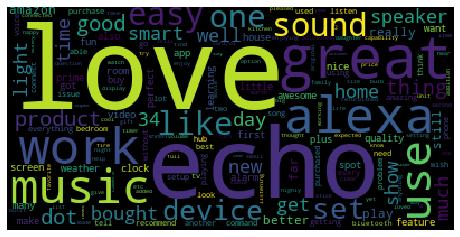

In [32]:
# create word cloud
createWordCloud(incorrect_pos_clean)

Misclassified positive reviews have terms that are more descriptive than correctly classified positive words. I suspect that the model learned to classify long, specific reviews as negative because people often don't write long positive reviews.

## Misclassified Negative Reviews

In [33]:
# create dictionary of indices and word counts
incorrect_neg_dict = correct.where(W.col('label')==1)\
                            .select('count_vec').rdd\
                            .map(lambda row: row.count_vec.toArray())\
                            .map(lambda row: key_val(row))\
                            .flatMap(lambda row: row)\
                            .reduceByKey(lambda x,y: x+y)\
                            .mapValues(lambda x: int(x))\
                            .collectAsMap()

In [34]:
# update the dictionary so the keys correspond to words
for i in range(0,len(vocab)):
    incorrect_neg_dict[vocab[i]] = incorrect_neg_dict.pop(i)

In [35]:
# get dictionary with values greater than 0
incorrect_neg_clean = {}
for k in incorrect_neg_dict.keys():
    if incorrect_neg_dict[k] > 0:
        incorrect_neg_clean[k] = incorrect_neg_dict[k]

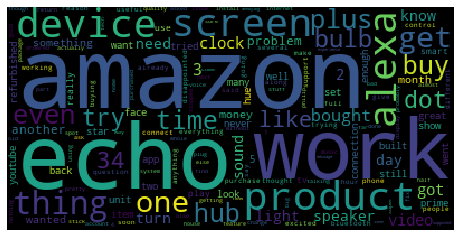

In [36]:
# create word cloud
createWordCloud(incorrect_neg_clean)

Misclassified negative reviews had fairly similar terms as correctly classified negative reviews. 